In [ ]:
import math
from typing import Tuple, List, Dict, Sized, Optional, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Зафиксируем зерна
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

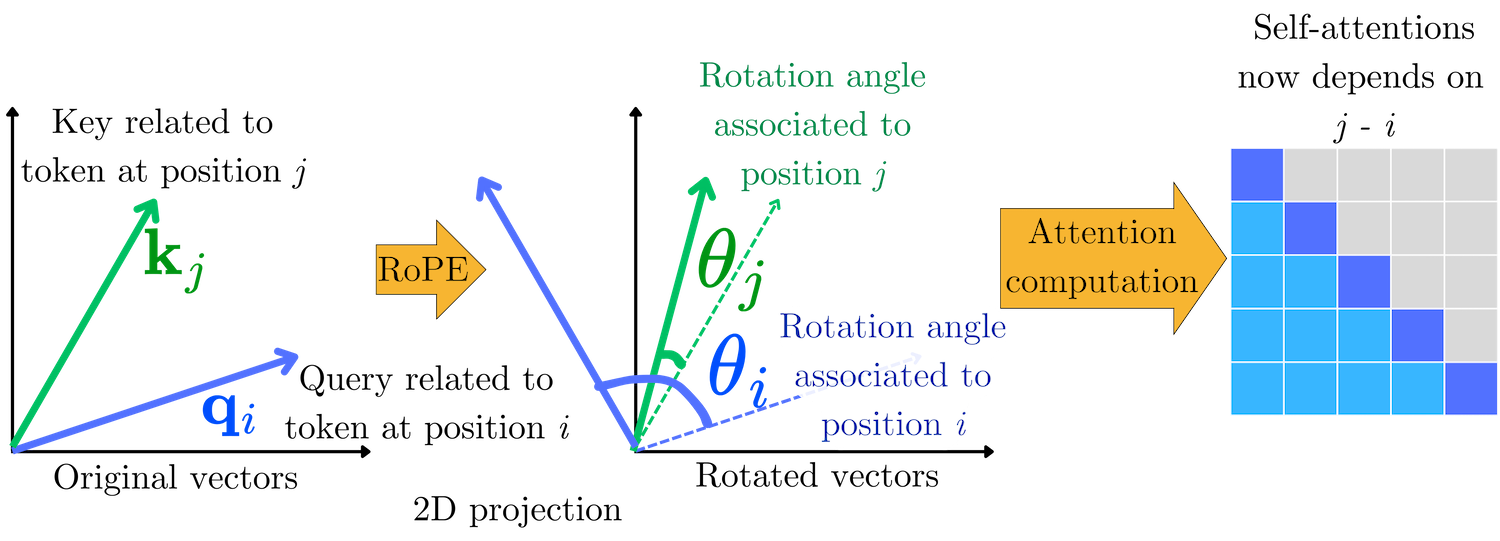

In [ ]:
class RotaryPositionalEmbedding(nn.Module):
    """
    Rotary Positional Embeddings for Transformers.

    This module applies rotary positional embeddings to input tensors, allowing the model to utilize 
    continuous position information in a more flexible manner compared to traditional learned embeddings.

    :param d: Dimension of the embeddings. Should be even.
    :param base: Base used for calculating positional encodings (default: 10,000).
    """
    
    def __init__(self, d: int, base: int = 10_000):
        super().__init__()
        if d % 2 != 0:
            raise ValueError("Dimension `d` for Rotary Positional Embedding must be even.")
        self.base = base
        self.d = d
        self.cos_cached = None
        self.sin_cached = None

    def _build_cache(self, max_pos: int, device: torch.device, dtype: torch.dtype):
        """Builds the cache for cosine and sine values."""
        if self.cos_cached is not None and max_pos <= self.cos_cached.shape[0]:
            return

        theta = 1. / (self.base ** (torch.arange(0, self.d, 2).float() / self.d)).to(device)
        seq_idx = torch.arange(max_pos, device=device, dtype=dtype)
        idx_theta = torch.einsum('n,d->nd', seq_idx, theta)
        idx_theta2 = torch.cat([idx_theta, idx_theta], dim=1)

        self.cos_cached = idx_theta2.cos()
        self.sin_cached = idx_theta2.sin()

    @staticmethod
    def _rotate_half(x: torch.Tensor):
        """Rotates half of the embedding dimension."""
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat([-x2, x1], dim=-1)

    def forward(self, x: torch.Tensor, pos: torch.Tensor=None):
        """
        Forward pass for the Rotary Positional Embeddings.

        This method applies the rotary positional embeddings to the input tensor.

        :param x: Input tensor of shape [batch, seq_len, d] 
        :param pos: Optional tensor of position indices, shape [batch, seq_len]. If None, indices are inferred as range(seq_len).
        :return: Tensor with applied rotary embeddings of the same shape as x.
        """
        batch_size, seq_len = x.shape[0], x.shape[1]
        
        if pos is None:
            pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)

        max_pos = pos.max().item() + 1
        
        self._build_cache(max_pos, device=x.device, dtype=x.dtype)
        
        x_rotated = self._rotate_half(x)
       
        x_rope = x * self.cos_cached[pos] + x_rotated * self.sin_cached[pos]

        return x_rope


In [ ]:
class RopeEmbeddingXY(nn.Module):

    def __init__(self, emb_dim: int, max_patches_xy: int = 128, freezed=True, separate=True):
        '''
        :param emb_dim: 
        :param max_patches_xy:
        :param freezed:
        :param separate: 
        '''
        super(RopeEmbeddingXY, self).__init__()
        assert emb_dim % 4 == 0, f'Embedding dimension must be divisible by 4'
        assert emb_dim > 4, f'Embedding dimension must be greater than 4'
   
        # YOUR CODE

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: input patches [B, D, H, W]
        :returns: output sequence [B, L, D]
        '''
        batch_size, emb_dim, patch_h, patch_w = x.shape
        
        # YOUR CODE
            
        return outp

def visualize_hw_encodings(input_patches: torch.Tensor, selected_ij: Tuple[int, int], encoding: nn.Module):  

    batch, emb_dim, p_H, p_W = input_patches.shape
    i, j = selected_ij
    enc = encoding.forward(input_patches)[0, ...] # get rid of batch dimension
    selected_enc = enc[i*p_W + j, :] 

    # Calculate dot products
    dot_products = enc @ selected_enc  # Shape: (num_patches,)

    # Reshape for visualization
    heatmap_data = dot_products.view(p_H, p_W).detach().numpy()    
    plt.figure(figsize=(p_W+2, p_H+2))

    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(heatmap_data, cmap=cmap,  square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

    # sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
    plt.title(f'Heatmap of Dot Products for Patch ({i}, {j})')
    plt.xlabel('Patch W')
    plt.ylabel('Patch H')
    plt.show()


In [ ]:
patch_size = 4
in_channels = 3
emb_dim = 64
p_H, p_W = 12, 16

x = torch.zeros(1, emb_dim, p_H, p_W)

pos_enc = RopeEmbeddingXY(emb_dim)

y = pos_enc(x)
print(y.shape)

visualize_hw_encodings(x, (6, 3), pos_enc)

visualize_hw_encodings(x, (6, 12), pos_enc)


In [ ]:
# Соберем все вместе

class ImageEmbedding(nn.Module):

    def __init__(self, patch_size: int, in_channels: int, emb_dim: int, dropout_rate: float = 0.1, freezed_pe = True):
        '''
        :param patch_size: int - size of the square patch
        :param in_channels: int - number of input channels
        :param emb_dim: int - embedding dimension
        :param dropout_rate: float - dropout rate
        :param freezed_pe: bool - freeze positional embeddings
        '''
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.emb_dim = emb_dim
        self.dropout_rate = dropout_rate
        self.freezed_pe = freezed_pe

        self.dropout = nn.Dropout(dropout_rate)
        self.img_emb = PatchEmbedding(patch_size=patch_size, channels=in_channels, emb_dim=emb_dim)
        
        self.pos_emb = SinusoidalEncodingXY(emb_dim=emb_dim, max_patches_xy=emb_dim//2, freezed=freezed_pe)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: torch.Tensor [B, C, H, W] - input image
        :returns: torch.Tensor [B, L, D] - output tokens (L=H*W//patch^2)
        '''
        x_patches = self.img_emb(x) # [B, D, pH, pW]

        return self.pos_emb(x_patches) # SinusoidalEncodingXY expects [B, D, pH, pW]


In [ ]:
batch_size = 1
patch_size = 16
in_channels = 3
emb_dim = 64

img_H, img_W = 224, 224

x = torch.zeros(batch_size, in_channels, img_H, img_W)
print(x.shape)

im2seq = ImageEmbedding(patch_size=patch_size, in_channels=in_channels, emb_dim=emb_dim)

y = im2seq(x)

print(y.shape)

In [ ]:
import lightning as L
import torchmetrics

class ImageClassifier(L.LightningModule):

    def __init__(
            self, 
            n_classes: int, 
            in_channels: int,
            patch_size: int, 
            emb_dim: int, 
            n_layers: int, 
            MHAnheads: int, 
            ff_dim: int, 
            dropout_rate: float, 
            freeze_pe: bool=True,
            ):
        '''
        :param n_classes: int - number of classes 
        :param in_channels: int - number of input channels
        :param patch_size: int - size of the square patch
        :param emb_dim: int - embedding dimension
        :param n_layers: int - number of layers
        :param MHAnheads: int - number of multihead attention heads
        :param ff_dim: int - hidden size of feedforward network in transformer
        :param dropout_rate: float - dropout rate
        '''
        super().__init__()
        self.save_hyperparameters()

        self.embedding = ImageEmbedding(
            patch_size=patch_size, in_channels=in_channels, emb_dim=emb_dim, 
            dropout_rate=dropout_rate, freezed_pe=freeze_pe
            )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=MHAnheads,
            dim_feedforward=ff_dim, dropout=dropout_rate,
            norm_first=True, batch_first=True,
            )

        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=n_layers)
        
        self.proj = nn.Linear(emb_dim, n_classes)

        self.CLS_token = nn.Parameter(torch.randn(emb_dim), requires_grad=True)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        :param x: torch.Tensor [B, C, H, W] - input image        
        :returns: torch.Tensor [B, N_CLS]

        '''
        batch_size = x.shape[0]
        x_emb = self.embedding.forward(x)
        x_cls = self.CLS_token.view(1, 1, -1).repeat(batch_size, 1, 1)
        x_emb = torch.cat((x_emb, x_cls), dim=1)

        x_enc = self.encoder.forward(x_emb)
        x_cls = x_enc[:, -1, :]

        logits = F.log_softmax(self.proj(x_cls), dim=-1)

        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

    def training_step(self, batch, batch_id: int):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_id: int):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("val_loss", loss)
        preds = torch.argmax(logits, dim=1)
        self.accuracy.update(preds, y)
        self.log("val_acc", self.accuracy, on_epoch=True, on_step=False)
        return loss

    def test_step(self, batch, batch_id: int):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log("test_loss", loss)
        preds = torch.argmax(logits, dim=1)
        self.accuracy.update(preds, y)
        self.log("test_acc", self.accuracy, on_epoch=True, on_step=False)
        return loss

In [ ]:
batch_size = 1
patch_size = 16
in_channels = 3
emb_dim = 64

img_H, img_W = 224, 224

x = torch.zeros(batch_size, in_channels, img_H, img_W)

model = ImageClassifier(10, in_channels, patch_size, emb_dim, 4, 4, 512, 0.1 )
preds = model(x)

preds.shape

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
import io

import pandas as pd
from PIL import Image
from typing import Dict, List, Optional

class CIFAR10Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.transform = transform
        self.load_and_preprocess_images(df)

    def load_and_preprocess_images(self, df: pd.DataFrame):
        """Load and preprocess images once during initialization."""
        images = []
        labels = []
        
        for idx in range(len(df)):
            row = df.iloc[idx]
            img_io = io.BytesIO(row['img']['bytes'])
            img = Image.open(img_io)
            label = row['label']

            if self.transform is not None:
                img = self.transform(img)

            images.append(img)
            labels.append(label)

        self.images = images
        self.labels = labels
    
    def __len__(self):

        return len(self.images)
    
    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:

        return self.images[idx], self.labels[idx]

    def get_loaders(
            self,
            names: Optional[List[str]] = ['train', 'val'],
            ratios: Optional[List[float]] = [0.9, 0.1],
            shuffle: Optional[List[bool]] = [True, False],
            batch_size: int = 8,
            load_ratio: int = 1.0,
            **kwargs,
        ) -> Dict[str, DataLoader]:
        """
        Fetches several dataloaders from this dataset
        """ 

        indices = list(range(len(self)))
        i0 = 0
        dataloaders: Dict[str, DataLoader] = {}
        
        for name, part, shuff in zip(names, ratios, shuffle):
            part_len = int(len(indices) * part * load_ratio )
            subset = Subset(self, indices[i0: i0 + part_len])
            dataloaders[name] = DataLoader(subset, batch_size, shuff, **kwargs)
            i0 += part_len        
            
        return dataloaders

    def loader(self, batch_size: int = 8, shuffle: bool =True, load_ratio: float = 1.0, **kwargs):
        
        indices = list(range(len(self)))
        subset = Subset(self, indices[: int(len(indices)*load_ratio)])
        return DataLoader(subset, batch_size, shuffle, **kwargs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, num_images=10):
    """Displays a grid of images from the dataset."""
    plt.figure(figsize=(15, 8))
    
    for i in range(num_images):
        img, label = dataset[i]
        img = np.transpose(img.numpy(), (1, 2, 0)) 
        
        img = (img * 0.5 + 0.5)  
        plt.subplot(2, 5, i + 1) 
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')  #

TF = transforms.Compose([
    # transforms.Resize((32, 32)),  # CIFAR-10 images are 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


dataset = CIFAR10Dataset(df_test, TF) 
show_images(dataset, 10)


In [ ]:

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

model = ImageClassifier(
    n_classes=10,
    in_channels=3,
    patch_size=4,
    emb_dim=64,
    n_layers=3,
    MHAnheads=8,
    ff_dim=256,
    dropout_rate=0.02,
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger("runs", name="vit_cifar10")

dl_train, dl_val = dataset_train.get_loaders(batch_size=16).values()

model.hparams.lr = 3e-3

trainer = Trainer(
    max_epochs=10, 
    accelerator="auto",
    devices=1,
    logger=logger,
    callbacks=[lr_monitor],
    enable_progress_bar=True,
    fast_dev_run=len(dl_train)+1,
)

trainer.fit(model, train_dataloaders=dl_train, val_dataloaders=dl_val)


In [ ]:
import optuna

def objective(trial: optuna.Trial):

    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    emb_dim = trial.suggest_categorical("emb_dim", [64, 128, 256])
    n_layers = trial.suggest_int("n_layers", 2, 6)
    MHAnheads = trial.suggest_categorical("MHAnheads", [4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [emb_dim * 2, emb_dim * 4])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    model = ImageClassifier(
        n_classes=10,
        in_channels=3,
        patch_size=8,
        emb_dim=emb_dim,
        n_layers=n_layers,
        MHAnheads=MHAnheads,
        ff_dim=ff_dim,
        dropout_rate=dropout_rate,
    )
    
    model.hparams.lr = lr
    dl_train, dl_val = dataset_train.get_loaders(batch_size=batch_size)

    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    logger = TensorBoardLogger("optuna_logs", name="vit_cifar10")

    trainer = Trainer(
        max_epochs=10, 
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[lr_monitor],
        enable_progress_bar=True, 
    )

    trainer.fit(model, train_dataloaders=dl_train, val_dataloaders=dl_val)

    return trainer.callback_metrics["val_acc"].item()

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5) 

    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    print("Best value:", study.best_value)
